# ========================================================================================
# JAX 1D-FDM + Unified Parameter Set for All Cases
# ========================================================================================
# 목적: 단일 파라미터 세트로 모든 실험 케이스(140W, 280W, 420W) 동시 피팅
#
# 전략 변경:
#   - 기존: 케이스별 독립 파라미터 (c, m, k) × 3 = 9개
#   - 신규: 단일 파라미터 세트로 모든 케이스 피팅
#
# 파라미터 구조:
#   1. c(Tw): 비선형 온도 의존 함수 (Shifted Tau 포화)
#      c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
#      - c_base: 저온 기준값 (복사 열전달 등)
#      - c_inf: 온도 증가에 따른 추가 증가분
#      - 저온에서 c_base로 시작, 고온에서 c_base + c_inf로 포화
#      - 항상 양수 보장: c_base < c < c_base + c_inf
#      - 범위: c(0°C)=c_base, c(1200°C)≈c_base + c_inf ✅
#   2. m: 끝단 열손실 강도 (단일 파라미터)
#   3. k: 전환 기울기
#   4. z1=0.1, z2=0.33: 전환점 위치 (고정 상수)
#
# hout 함수:
#   hout(z, Tw) = c(Tw) + m/k*ln(1+exp(k*(z1-z))) + m/k*ln(1+exp(k*(z-z2)))
#   where c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
#
# 학습 파라미터:
#   - c_base, c_inf, T0: c(Tw) 함수 파라미터 (3개)
#   - m: 끝단 열손실 강도 (1개)
#   - k: 전환 기울기 (1개)
#   - 총 5개 파라미터 (기존 9개 → 5개로 감소, 44%!)
#
# 물리적 의미:
#   - c(Tw) Shifted Tau: c_base (복사) + 포화 대류
#   - c_base: 저온 기준 열전달계수 (≈15~20 예상)
#   - c_inf: 온도 증가에 따른 추가 증가분 (≈30~40 예상)
#   - T0: 포화 시간 상수 (≈500~1000°C 예상)
#   - m 단일: 좌우 대칭 열손실 패턴
#   - k: 전환 기울기는 모든 케이스에서 동일
#   - z1, z2 고정: 0.1, 0.33 m (상수)
#
# 고정 파라미터:
#   - hwi = 0.0
#   - hwo = 0.0
#   - z1 = 0.1 m
#   - z2 = 0.33 m
# ========================================================================================

In [179]:
# 0) 라이브러리 로드
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import lax
from jax import custom_vjp
import optax

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]


In [180]:
# 1) 데이터 로드 및 설정
tc_pos = jnp.array(json.load(open('tc_pos.json')))
T_140 = jnp.array(json.load(open('Temp_profile_140W.json')))
T_280 = jnp.array(json.load(open('Temp_profile_280W.json')))
T_420 = jnp.array(json.load(open('Temp_profile_420W.json')))

powers = jnp.array([140.0, 280.0, 420.0])
T_meas_cases = jnp.array([T_140, T_280, T_420])
num_cases, n_TC = T_meas_cases.shape

print(f"Cases: {num_cases}, TC count: {n_TC}")

# 2) Geometry
L = 430e-3; ID = 5.03e-3; OD = 6.33e-3
Ai = jnp.pi * ID**2 / 4; Ao = jnp.pi * OD**2 / 4; Aw = Ao - Ai
pri = jnp.pi * ID; pro = jnp.pi * OD
dz = 0.001; n_nodes = int(L/dz) + 1; z = jnp.linspace(0, L, n_nodes)
Awg = pri * dz; Aout = pro * dz
tc_idx = jnp.array([jnp.argmin(jnp.abs(z - zp)) for zp in tc_pos])

print(f"Nodes: {n_nodes}, Grid: {dz*1000:.2f} mm")

# 3) Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he); df_kt = pd.read_csv(path_kt); 
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]; df_kt_cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]
Mw_he = 4.0026

## Jax-friendly 1D interpolation
def interp1d(xq, x, y):
    xq = jnp.asarray(xq)
    x  = jnp.asarray(x)
    y  = jnp.asarray(y)
    return jnp.interp(xq, x, y)

def rho_he(T): return interp1d(T, df_he['T [C]'], df_he['rho [kg/m3]'])
def cp_he(T): return interp1d(T, df_he['T [C]'], df_he['Cp [J/mol*K]'])
def k_he(T): return interp1d(T, df_he['T [C]'], df_he['Tc [W/m*K]'])
def rho_kt(T): return interp1d(T, df_kt['T [C]'], df_kt['rho [kg/m3]'])
def cp_kt(T): return interp1d(T, df_kt_cp['T [C]'], df_kt_cp['Cp [kJ/kg*K]'])*1000
def k_kt(T): return interp1d(T, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])
def h_wg(Tg): return 4.36 * k_he(Tg) / ID

# 4) Feed conditions
P = 101325.0; Tamb = 25.0; Fv_std = 50.0
Fw = Fv_std * 1e-6 / 60 * rho_he(0)
F = Fw / Mw_he * 1000.0

print("Setup complete")

Cases: 3, TC count: 16
Nodes: 431, Grid: 1.00 mm
Setup complete


In [181]:
# 5) 비선형 온도 의존 c(Tw) 함수 및 hout(z, Tw) 정의

# 고정 상수
Z1_FIXED = 0.1
Z2_FIXED = 0.33

def compute_c_of_Tw(c_params, Tw_local):
    """
    비선형 온도 의존 c(Tw) 계산 (Shifted Tau 포화)
    
    c_params: [c_base, c_inf, T0]
    c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
    
    - c_base: 저온 기준값 (복사 열전달 등)
    - c_inf: 온도 증가에 따른 추가 증가분
    - 저온: c_base에서 시작
    - 고온: c_base + c_inf로 포화
    - 항상 양수: c_base < c < c_base + c_inf
    
    Tw_local: 국부 벽면 온도 [°C]
    c_base: 저온 기준 열전달계수
    c_inf: 포화 증가분
    T0: 포화 시간 상수 [°C]
    """
    c_base, c_inf, T0 = c_params[0], c_params[1], c_params[2]
    # Shifted Tau 포화 함수 (항상 양수)
    c_Tw = c_base + c_inf * (1.0 - jnp.exp(-Tw_local / (T0 + 1e-6)))
    return c_Tw

def compute_hout_profile(global_params, Tw):
    """
    위치 z 및 온도 Tw에 대한 hout(z, Tw) 프로파일 계산
    
    global_params: [c_base, c_inf, T0, m, k]
    Tw: 벽면 온도 배열 (n_nodes,)
    
    hout(z, Tw) = c(Tw) + m/k*ln(1+exp(k*(z1-z))) + m/k*ln(1+exp(k*(z-z2)))
    where c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
    
    z1, z2는 고정 상수 (0.1, 0.33 m)
    """
    c_base, c_inf, T0, m, k = global_params[0], global_params[1], global_params[2], global_params[3], global_params[4]
    
    # c(Tw): 비선형 온도 의존 기본 열전달계수 (Shifted Tau 포화)
    c_Tw = c_base + c_inf * (1.0 - jnp.exp(-Tw / (T0 + 1e-6)))
    
    # 위치 의존 항: 끝단 열손실 (z1, z2는 고정)
    # softplus 함수 사용: ln(1+exp(x))
    z_term1 = (m / k) * jnp.log(1 + jnp.exp(k * (Z1_FIXED - z)))  # 좌측 끝단
    z_term2 = (m / k) * jnp.log(1 + jnp.exp(k * (z - Z2_FIXED)))  # 우측 끝단
    
    hout_profile = c_Tw + z_term1 + z_term2
    return hout_profile

print("c(Tw) and hout(z, Tw) functions defined with Shifted Tau saturation c(Tw)")
print(f"  c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))")
print(f"  항상 양수: c_base < c < c_base + c_inf")
print(f"  저온 시작값: c(0°C) = c_base")
print(f"  고온 포화값: c(∞) = c_base + c_inf")
print(f"  z1 = {Z1_FIXED} m (fixed)")
print(f"  z2 = {Z2_FIXED} m (fixed)")

c(Tw) and hout(z, Tw) functions defined with Shifted Tau saturation c(Tw)
  c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
  항상 양수: c_base < c < c_base + c_inf
  저온 시작값: c(0°C) = c_base
  고온 포화값: c(∞) = c_base + c_inf
  z1 = 0.1 m (fixed)
  z2 = 0.33 m (fixed)


In [182]:
# 6) Residual function with temperature-dependent hout

HWI_FIXED = 0.
HWO_FIXED = 0.

def residual(U, global_params, Pw):
    """
    global_params: [c0, c1, m1, m2, k, z1, z2]
    hwi, hwo는 고정값 사용
    """
    hwi = HWI_FIXED
    hwo = HWO_FIXED
    
    Tw = U[:n_nodes]; Tg = U[n_nodes:]
    
    # hout(z, Tw) 프로파일 계산 - Tw 의존
    hout_profile = compute_hout_profile(global_params, Tw)
    
    kw = k_kt(Tw); cpg = cp_he(Tg); hwg = h_wg(Tg)
    Qelec = Pw * dz / L
    rw = jnp.zeros((n_nodes,)); rg = jnp.zeros((n_nodes,))
    
    # Wall BC
    rw = rw.at[0].set(hwi * Aw * (Tw[0] - Tamb) + kw[0] * Aw * (Tw[0] - Tw[1]) / dz)
    rw = rw.at[-1].set(hwo * Aw * (Tw[-1] - Tamb) + kw[-1] * Aw * (Tw[-1] - Tw[-2]) / dz)
    
    # Wall interior - hout은 위치 및 온도별로 다름
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout_profile[1:-1] * Aout * (Tw[1:-1] - Tamb)  # 위치 및 온도별 hout 사용
    rw = rw.at[1:-1].set(Qcond + (Qelec/dz) - (Qwg/dz) - (Qout/dz))
    
    # Gas BC & interior
    rg = rg.at[0].set(Tg[0] - Tw[0])
    rg = rg.at[-1].set(Tg[-1] - Tw[-1])
    gflux = F * cpg[1:-1] * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set((Qwg/dz) - gflux)
    
    return jnp.concatenate([rw, rg])

# 7) Newton solver (forward only)
def newton_step(residual_fn, damping=1.0):
    def step(U, _):
        F = residual_fn(U)
        J = jax.jacfwd(residual_fn)(U)
        dU = jnp.linalg.solve(J, -F)
        U_new = U + damping * dU
        return U_new, (jnp.linalg.norm(F), jnp.linalg.norm(dU))
    return step

def newton_solve_forward(residual_fn, U0, iters=20, damping=1.0):
    step = newton_step(residual_fn, damping)
    U_final, (res_hist, step_hist) = lax.scan(step, U0, xs=None, length=iters)
    return U_final, res_hist, step_hist

print("Residual and Newton solver defined with temperature-dependent hout")

Residual and Newton solver defined with temperature-dependent hout


In [183]:
# 8) Implicit Differentiation Newton Solver
@custom_vjp
def newton_solve_implicit(global_params, Pw, U0, iters=20, damping=1.0):
    res_fn = lambda U: residual(U, global_params, Pw)
    U_final, _, _ = newton_solve_forward(res_fn, U0, iters, damping)
    return U_final

def newton_solve_implicit_fwd(global_params, Pw, U0, iters, damping):
    U_star = newton_solve_implicit(global_params, Pw, U0, iters, damping)
    return U_star, (global_params, Pw, U_star)

def newton_solve_implicit_bwd(res, g):
    global_params, Pw, U_star = res
    res_fn = lambda U: residual(U, global_params, Pw)
    J = jax.jacfwd(res_fn)(U_star)
    lmbda = jnp.linalg.solve(J.T, g)
    
    def res_wrt_global_params(gp):
        return residual(U_star, gp, Pw)
    _, vjp_global_params = jax.vjp(res_wrt_global_params, global_params)
    grad_global_params = vjp_global_params(-lmbda)[0]
    
    def res_wrt_Pw(p):
        return residual(U_star, global_params, p)
    _, vjp_Pw = jax.vjp(res_wrt_Pw, Pw)
    grad_Pw = vjp_Pw(-lmbda)[0]
    
    grad_U0 = jnp.zeros_like(U_star)
    return (grad_global_params, grad_Pw, grad_U0, None, None)

newton_solve_implicit.defvjp(newton_solve_implicit_fwd, newton_solve_implicit_bwd)

print("Implicit differentiation solver ready")

Implicit differentiation solver ready


## 단일 파라미터 세트 학습: c_base, c_inf, T0, m, k (5개 파라미터)

In [184]:
# 9) Fitting setup - 단일 글로벌 파라미터 세트 학습 (Shifted Tau 포화 c(Tw))

LEARNING_RATE = 1e0

def global_params_phys(global_params_raw):
    """
    global_params_raw를 물리적으로 유효한 global_params로 변환
    global_params = [c_base, c_inf, T0, m, k]
    """
    eps = 1e-6
    params = jax.nn.softplus(global_params_raw) + eps
    
    # 물리적 범위 제약
    c_base = jnp.clip(params[0], 5.0, 50.0)    # 저온 기준값
    c_inf = jnp.clip(params[1], 10.0, 100.0)   # 포화 증가분
    T0 = jnp.clip(params[2], 100.0, 2000.0)    # 포화 시간 상수 [°C]
    m = jnp.clip(params[3], 10.0, 250.0)       # 끝단 열손실 강도
    k = jnp.clip(params[4], 10.0, 200.0)       # 전환 기울기
    
    return jnp.array([c_base, c_inf, T0, m, k])

def softplus_inv(h):
    return jnp.log(jnp.exp(h) - 1.0)

# 초기값 설정
# c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
# 저온(≈500°C): c ≈ 25 → c_base + c_inf*(1-exp(-500/T0)) = 25
# 중온(≈700°C): c ≈ 43 → c_base + c_inf*(1-exp(-700/T0)) = 43
# 고온(≈900°C): c ≈ 50 → c_base + c_inf*(1-exp(-900/T0)) = 50
# 초기 추정: c_base ≈ 15, c_inf ≈ 40, T0 ≈ 800

global_params_init = jnp.array([
    15.0,    # c_base (저온 기준)
    40.0,    # c_inf (포화 증가분)
    800.0,   # T0 [°C] (포화 시간 상수)
    250.0,   # m
    78.0     # k
])

global_params_raw = softplus_inv(global_params_init)

# 초기 상태
Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])
U0_cases = jnp.stack([U0, U0, U0])

def predict_TC(U):
    return U[:n_nodes][tc_idx]

def case_loss(global_params, Pw, U0, T_meas):
    """단일 케이스 손실함수"""
    U_star = newton_solve_implicit(global_params, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, U_star

def total_loss(global_params_raw, U0_cases, T_meas_cases, powers):
    """전체 손실함수 (3개 케이스, 단일 파라미터 세트)"""
    global_params = global_params_phys(global_params_raw)
    
    def one_case(U0_k, T_k, Pw_k):
        loss_k, _ = case_loss(global_params, Pw_k, U0_k, T_k)
        return loss_k
    
    losses = jax.vmap(one_case)(U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update(global_params_raw, U0_cases, T_meas_cases, powers):
    """Warm-start 업데이트"""
    global_params = global_params_phys(global_params_raw)
    
    def one_case(U0_k, T_k, Pw_k):
        _, U_star = case_loss(global_params, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)
    
    return jax.vmap(one_case)(U0_cases, T_meas_cases, powers)

def get_newton_convergence(global_params_raw, U0_cases, T_meas_cases, powers):
    """Newton 수렴성 진단"""
    global_params = global_params_phys(global_params_raw)
    
    def one_case(U0_k, T_k, Pw_k):
        res_fn = lambda U: residual(U, global_params, Pw_k)
        _, res_hist, step_hist = newton_solve_forward(res_fn, U0_k, iters=20, damping=1.0)
        return res_hist[-1], step_hist[-1]
    
    res_norms, step_norms = jax.vmap(one_case)(U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

print("="*80)
print("Fitting Setup - Shifted Tau Saturation c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))")
print("="*80)
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))")
print(f"  - 항상 양수 보장: c_base < c < c_base + c_inf")
print(f"  - hout(z, Tw) = c(Tw) + m/k*ln(1+exp(k*(z1-z))) + m/k*ln(1+exp(k*(z-z2)))")
print(f"  - 학습 파라미터: [c_base, c_inf, T0, m, k] (총 5개)")
print(f"  - 고정 상수: z1={Z1_FIXED} m, z2={Z2_FIXED} m")
print(f"  - 초기값:")
print(f"    c_base = {global_params_init[0]:.2f} (저온 기준)")
print(f"    c_inf  = {global_params_init[1]:.2f} (포화 증가분)")
print(f"    T0     = {global_params_init[2]:.2f} °C")
print(f"    m      = {global_params_init[3]:.1f}")
print(f"    k      = {global_params_init[4]:.1f}")
print(f"  - 예상 범위:")
print(f"    c(0°C)    = {global_params_init[0]:.1f}")
print(f"    c(600°C)  ≈ {global_params_init[0] + global_params_init[1]*(1-np.exp(-600/global_params_init[2])):.1f}")
print(f"    c(1200°C) ≈ {global_params_init[0] + global_params_init[1]*(1-np.exp(-1200/global_params_init[2])):.1f}")
print("="*80)

Fitting Setup - Shifted Tau Saturation c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
  - Learning rate: 1.0
  - c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
  - 항상 양수 보장: c_base < c < c_base + c_inf
  - hout(z, Tw) = c(Tw) + m/k*ln(1+exp(k*(z1-z))) + m/k*ln(1+exp(k*(z-z2)))
  - 학습 파라미터: [c_base, c_inf, T0, m, k] (총 5개)
  - 고정 상수: z1=0.1 m, z2=0.33 m
  - 초기값:
    c_base = 15.00 (저온 기준)
    c_inf  = 40.00 (포화 증가분)
    T0     = 800.00 °C
    m      = 250.0
    k      = 78.0
  - 예상 범위:
    c(0°C)    = 15.0
    c(600°C)  ≈ 36.1
    c(1200°C) ≈ 46.1


In [ ]:
# 10) Training loop
opt = optax.adam(learning_rate=LEARNING_RATE)
opt_state = opt.init(global_params_raw)
loss_and_grad = jax.value_and_grad(total_loss)

print("="*80)
print("TRAINING START: Shifted Tau c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))")
print("="*80)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: 200")
print(f"All cases share the same parameter set")
print("="*80)

history = {
    'loss': [],
    'loss_per_case': [],
    'c_base': [],
    'c_inf': [],
    'T0': [],
    'm': [],
    'k': [],
    'grads': [],
    'newton_res': [],
    'newton_step': []
}

for step in range(100):
    loss, grads = loss_and_grad(global_params_raw, U0_cases, T_meas_cases, powers)
    updates, opt_state = opt.update(grads, opt_state)
    global_params_raw = optax.apply_updates(global_params_raw, updates)
    
    res_norms, step_norms = get_newton_convergence(global_params_raw, U0_cases, T_meas_cases, powers)
    U0_cases = warm_start_update(global_params_raw, U0_cases, T_meas_cases, powers)
    
    global_params = global_params_phys(global_params_raw)
    
    # 케이스별 손실 계산
    def compute_case_losses(gp, U0s, Ts, Pws):
        def one_loss(U0_k, T_k, Pw_k):
            loss_k, _ = case_loss(gp, Pw_k, U0_k, T_k)
            return loss_k
        return jax.vmap(one_loss)(U0s, Ts, Pws)
    
    case_losses = compute_case_losses(global_params, U0_cases, T_meas_cases, powers)
    
    history['loss'].append(float(loss))
    history['loss_per_case'].append(np.array(case_losses))
    history['c_base'].append(float(global_params[0]))
    history['c_inf'].append(float(global_params[1]))
    history['T0'].append(float(global_params[2]))
    history['m'].append(float(global_params[3]))
    history['k'].append(float(global_params[4]))
    history['grads'].append(np.array(grads))
    history['newton_res'].append(np.array(res_norms))
    history['newton_step'].append(np.array(step_norms))
    
    # 매 20 epoch마다 출력
    if step % 1 == 0 or step < 5:
        print(f'\nEPOCH {step:04d} | Total Loss = {float(loss):.6e}')
        print(f'  Global Params:')
        print(f'    c_base={float(global_params[0]):.4f}, c_inf={float(global_params[1]):.4f}, T0={float(global_params[2]):.3f}')
        print(f'    m={float(global_params[3]):.3f}, k={float(global_params[4]):.3f}')
        print(f'  Gradients:')
        print(f'    ∇c_base={float(grads[0]):.3e}, ∇c_inf={float(grads[1]):.3e}, ∇T0={float(grads[2]):.3e}')
        print(f'    ∇m={float(grads[3]):.3e}, ∇k={float(grads[4]):.3e}')
        print(f'  Case Losses:')
        for k, (Pw_k, loss_k) in enumerate(zip([140., 280., 420.], case_losses)):
            print(f'    Case {k+1} ({Pw_k}W): Loss={float(loss_k):.3e}, ||F||={float(res_norms[k]):.2e}')

print(f'\n{"="*80}')
print("TRAINING COMPLETE")
print(f'{"="*80}')

TRAINING START: Shifted Tau c(Tw) = c_base + c_inf * (1 - exp(-Tw/T0))
Learning rate: 1.0
Epochs: 200
All cases share the same parameter set



EPOCH 0000 | Total Loss = 1.894588e+05
  Global Params:
    c_base=16.0000, c_inf=41.0000, T0=2000.000
    m=250.000, k=77.000
  Gradients:
    ∇c_base=-2.716e+04, ∇c_inf=-1.215e+04, ∇T0=0.000e+00
    ∇m=0.000e+00, ∇k=2.680e+02
  Case Losses:
    Case 1 (140.0W): Loss=7.473e+02, ||F||=1.86e-01
    Case 2 (280.0W): Loss=4.869e+04, ||F||=3.68e-01
    Case 3 (420.0W): Loss=1.039e+05, ||F||=5.48e-01

EPOCH 0001 | Total Loss = 1.533370e+05
  Global Params:
    c_base=16.9910, c_inf=41.9902, T0=2000.000
    m=250.000, k=76.007
  Gradients:
    ∇c_base=-2.260e+04, ∇c_inf=-1.000e+04, ∇T0=0.000e+00
    ∇m=0.000e+00, ∇k=2.312e+02
  Case Losses:
    Case 1 (140.0W): Loss=1.648e+03, ||F||=1.68e-01
    Case 2 (280.0W): Loss=3.818e+04, ||F||=2.42e-01
    Case 3 (420.0W): Loss=8.391e+04, ||F||=5.37e-01

EPOCH 0002 | Total Loss = 1.237348e+05
  Global Params:
    c_base=17.9669, c_inf=42.9643, T0=2000.000
    m=250.000, k=75.024
  Gradients:
    ∇c_base=-1.867e+04, ∇c_inf=-8.195e+03, ∇T0=0.000e+00
  

KeyboardInterrupt: 

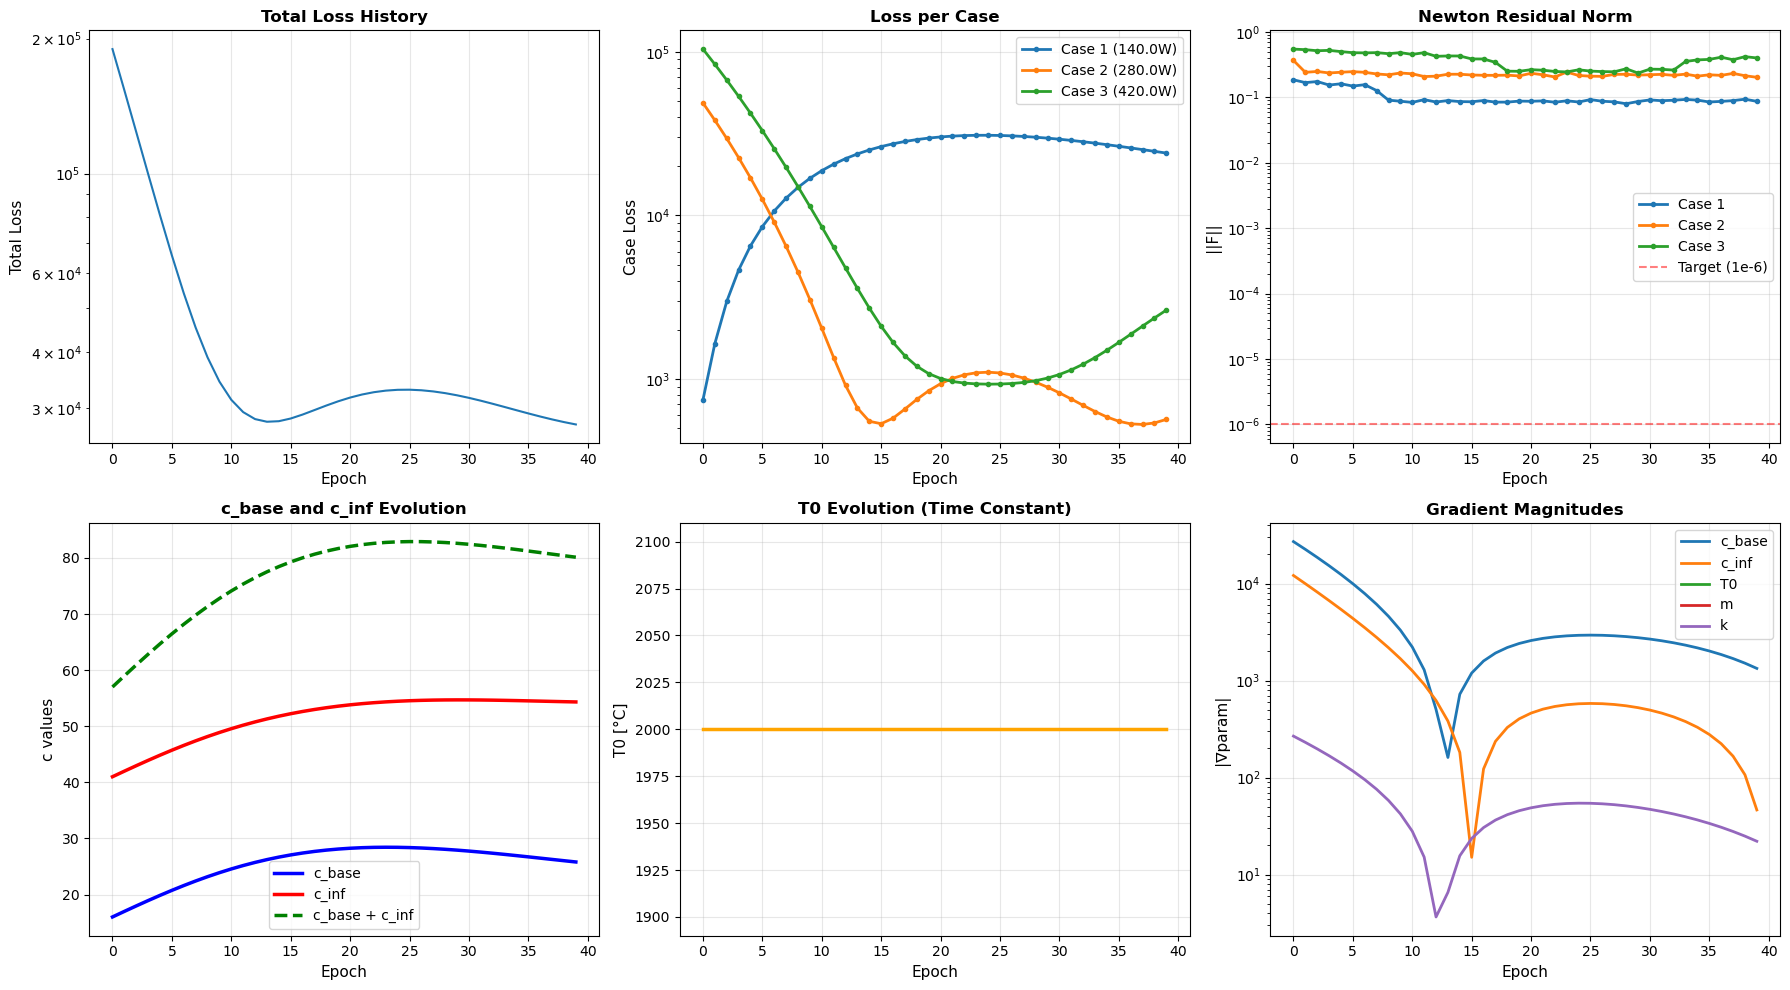

In [ ]:
# 11) Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Loss histories and convergence
# Total loss
axes[0, 0].semilogy(history['loss'])
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Total Loss', fontsize=11)
axes[0, 0].set_title('Total Loss History', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Case-wise losses
loss_per_case = np.array(history['loss_per_case'])
for k in range(3):
    axes[0, 1].semilogy(loss_per_case[:, k], label=f'Case {k+1} ({powers[k]}W)',
                        marker='o', markersize=3, linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Case Loss', fontsize=11)
axes[0, 1].set_title('Loss per Case', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Newton convergence
newton_res = np.array(history['newton_res'])
for k in range(3):
    axes[0, 2].semilogy(newton_res[:, k], label=f'Case {k+1}',
                        marker='o', markersize=3, linewidth=2)
axes[0, 2].axhline(1e-6, color='r', linestyle='--', alpha=0.5, label='Target (1e-6)')
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('||F||', fontsize=11)
axes[0, 2].set_title('Newton Residual Norm', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Parameters
# c_base and c_inf evolution
axes[1, 0].plot(history['c_base'], linewidth=2.5, color='blue', label='c_base')
axes[1, 0].plot(history['c_inf'], linewidth=2.5, color='red', label='c_inf')
c_total = np.array(history['c_base']) + np.array(history['c_inf'])
axes[1, 0].plot(c_total, linewidth=2.5, color='green', linestyle='--', label='c_base + c_inf')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('c values', fontsize=11)
axes[1, 0].set_title('c_base and c_inf Evolution', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# T0 evolution
axes[1, 1].plot(history['T0'], linewidth=2.5, color='orange')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('T0 [°C]', fontsize=11)
axes[1, 1].set_title('T0 Evolution (Time Constant)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Gradient magnitudes
grads_array = np.array(history['grads'])
param_names = ['c_base', 'c_inf', 'T0', 'm', 'k']
for i, name in enumerate(param_names):
    axes[1, 2].semilogy(np.abs(grads_array[:, i]), label=name, linewidth=2)
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('|∇param|', fontsize=11)
axes[1, 2].set_title('Gradient Magnitudes', fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINAL RESULTS - Tau Saturation c(Tw) = c_inf * (1 - exp(-Tw/T0))

Global Parameters (shared across all cases):
  c_inf = 25.802156
  T0 = 54.332 °C
  m  = 2000.000
  k  = 250.000

Fixed Constants:
  z1 = 0.1 m
  z2 = 0.33 m

c(Tw) = c_inf * (1 - exp(-Tw/T0)) function:
  c(0°C) = 0.000, dc/dT = 0.474901
  c(300°C) = 25.699, dc/dT = 0.001899
  c(600°C) = 25.802, dc/dT = 0.000008
  c(900°C) = 25.802, dc/dT = 0.000000
  c(1200°C) = 25.802, dc/dT = 0.000000

케이스 1 (140.0W):
  Tw range:             319.2 ~ 466.2 °C
  c(Tw) range:          25.730 ~ 25.797
  hout(z=0):            58.820
  hout(z=L/2):          37.101
  hout(z=L):            58.837
  Newton:               ||F||=8.714e-02
  TC MSE:               2.406e+04


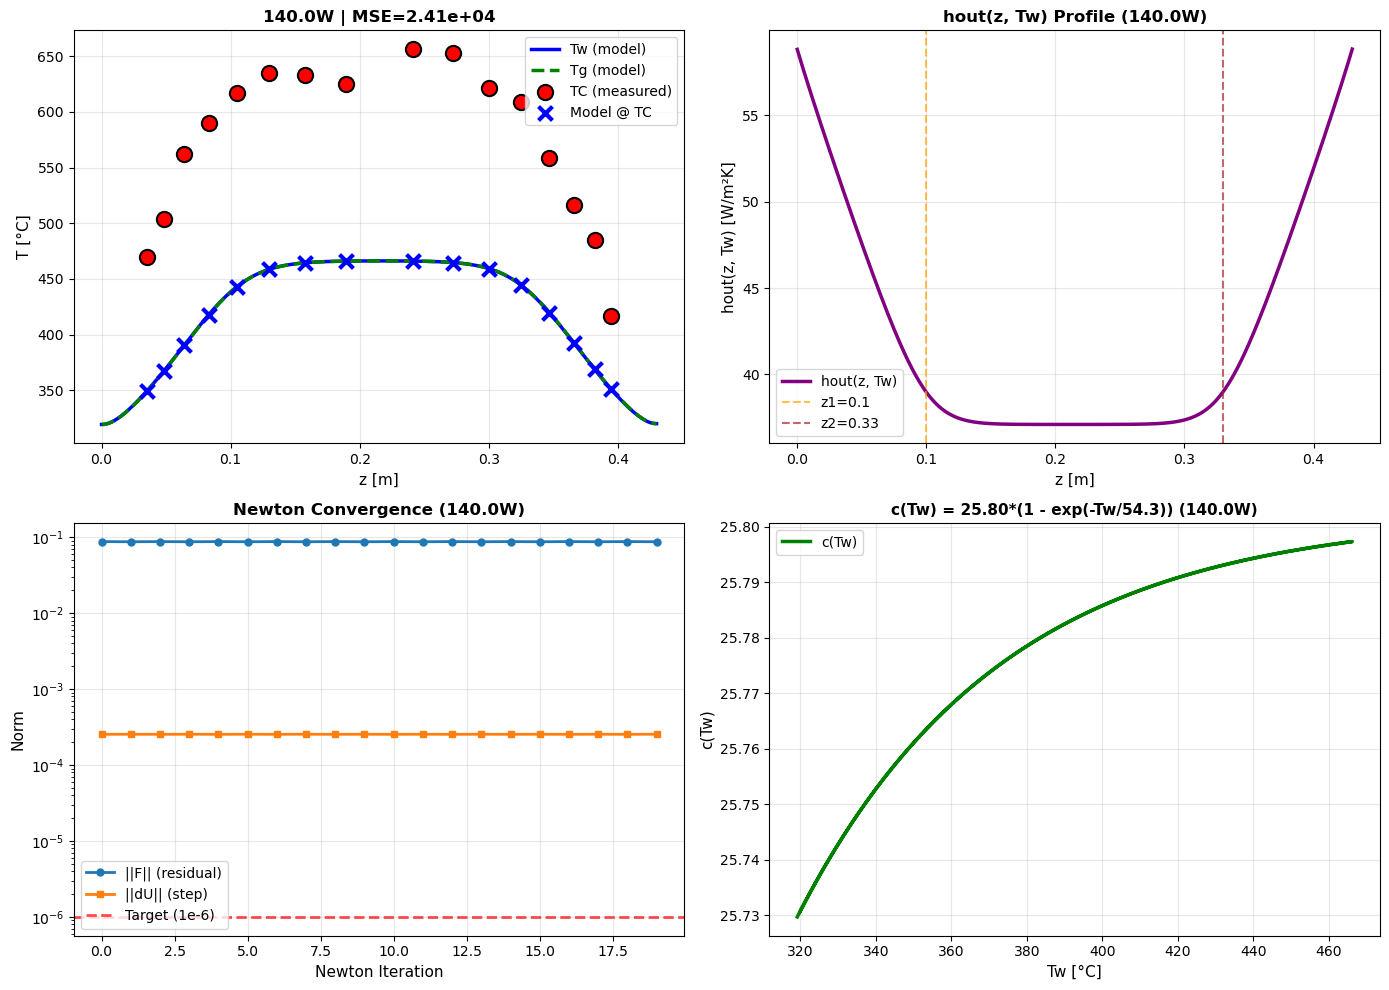


케이스 2 (280.0W):
  Tw range:             563.3 ~ 780.1 °C
  c(Tw) range:          25.801 ~ 25.802
  hout(z=0):            64.141
  hout(z=L/2):          43.353
  hout(z=L):            64.162
  Newton:               ||F||=2.082e-01
  TC MSE:               5.670e+02


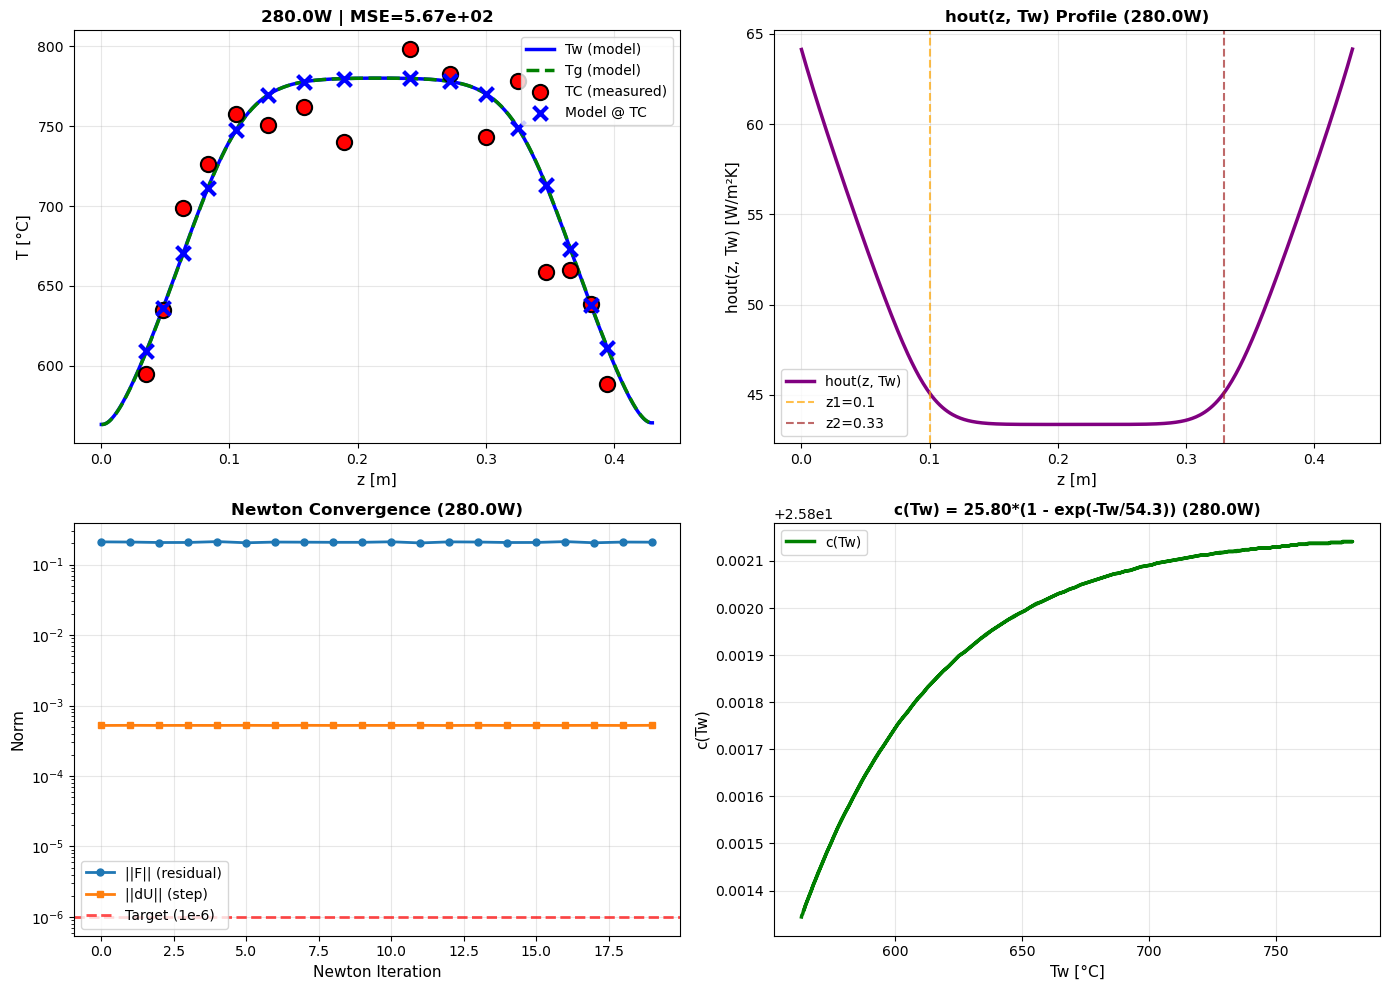


케이스 3 (420.0W):
  Tw range:             780.5 ~ 1048.6 °C
  c(Tw) range:          25.802 ~ 25.802
  hout(z=0):            68.360
  hout(z=L/2):          47.973
  hout(z=L):            68.382
  Newton:               ||F||=4.334e-01
  TC MSE:               2.640e+03


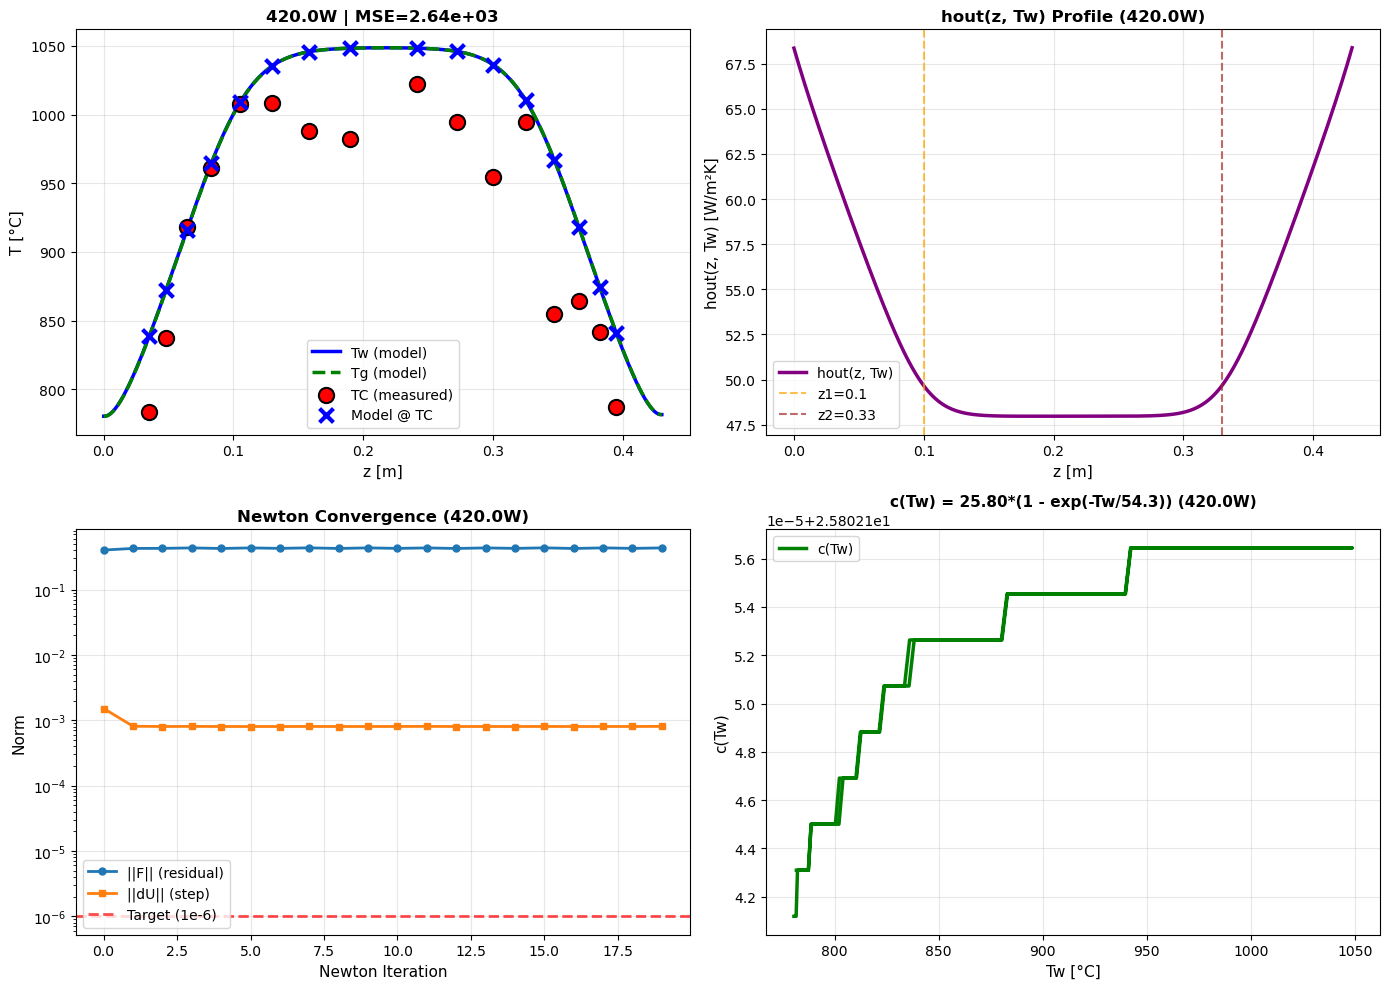

In [ ]:
# 12) Final results with hout(z, Tw) profile visualization
global_params_final = global_params_phys(global_params_raw)

print("\n" + "="*80)
print("FINAL RESULTS - Tau Saturation c(Tw) = c_inf * (1 - exp(-Tw/T0))")
print("="*80)
print(f"\nGlobal Parameters (shared across all cases):")
print(f"  c_inf = {float(global_params_final[0]):.6f}")
print(f"  T0 = {float(global_params_final[1]):.3f} °C")
print(f"  m  = {float(global_params_final[2]):.3f}")
print(f"  k  = {float(global_params_final[3]):.3f}")
print(f"\nFixed Constants:")
print(f"  z1 = {Z1_FIXED} m")
print(f"  z2 = {Z2_FIXED} m")
print("\nc(Tw) = c_inf * (1 - exp(-Tw/T0)) function:")
for T_sample in [0, 300, 600, 900, 1200]:
    c_val = float(global_params_final[0]) * (1 - np.exp(-T_sample / float(global_params_final[1])))
    dc_dT = float(global_params_final[0]) * np.exp(-T_sample / float(global_params_final[1])) / float(global_params_final[1])
    print(f"  c({T_sample}°C) = {c_val:.3f}, dc/dT = {dc_dT:.6f}")
print("="*80)

for k, Pw_k in enumerate([140., 280., 420.]):
    res_fn = lambda U: residual(U, global_params_final, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    # hout(z, Tw) 프로파일 계산
    hout_profile = compute_hout_profile(global_params_final, Tw)
    c_Tw_profile = float(global_params_final[0]) * (1.0 - jnp.exp(-Tw / (float(global_params_final[1]) + 1e-6)))
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  Tw range:             {float(Tw.min()):.1f} ~ {float(Tw.max()):.1f} °C")
    print(f"  c(Tw) range:          {float(c_Tw_profile.min()):.3f} ~ {float(c_Tw_profile.max()):.3f}")
    print(f"  hout(z=0):            {float(hout_profile[0]):.3f}")
    print(f"  hout(z=L/2):          {float(hout_profile[n_nodes//2]):.3f}")
    print(f"  hout(z=L):            {float(hout_profile[-1]):.3f}")
    print(f"  Newton:               ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:               {mse:.3e}")
    
    # Temperature and hout profile
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Temperature profile
    axes[0, 0].plot(np.array(z), np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    axes[0, 0].plot(np.array(z), np.array(Tg), label='Tg (model)', linewidth=2.5,
                    linestyle='--', color='green')
    axes[0, 0].scatter(np.array(tc_pos), np.array(T_meas_cases[k]), s=120, c='red',
                       label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    axes[0, 0].scatter(np.array(tc_pos), np.array(Tw_tc), s=100, c='blue', marker='x',
                       linewidths=3, label='Model @ TC', zorder=5)
    axes[0, 0].set_title(f'{Pw_k}W | MSE={mse:.2e}', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].set_xlabel('z [m]', fontsize=11)
    axes[0, 0].set_ylabel('T [°C]', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # hout(z, Tw) profile
    axes[0, 1].plot(np.array(z), np.array(hout_profile), linewidth=2.5, color='purple', label='hout(z, Tw)')
    axes[0, 1].axvline(Z1_FIXED, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z1={Z1_FIXED}')
    axes[0, 1].axvline(Z2_FIXED, color='brown', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z2={Z2_FIXED}')
    axes[0, 1].set_title(f'hout(z, Tw) Profile ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].set_xlabel('z [m]', fontsize=11)
    axes[0, 1].set_ylabel('hout(z, Tw) [W/m²K]', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Newton convergence
    axes[1, 0].semilogy(np.array(res_hist), label='||F|| (residual)', marker='o',
                        markersize=5, linewidth=2)
    axes[1, 0].semilogy(np.array(step_hist), label='||dU|| (step)', marker='s',
                        markersize=5, linewidth=2)
    axes[1, 0].axhline(1e-6, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Target (1e-6)')
    axes[1, 0].set_title(f'Newton Convergence ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].set_xlabel('Newton Iteration', fontsize=11)
    axes[1, 0].set_ylabel('Norm', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # c(Tw) vs Tw
    axes[1, 1].plot(np.array(Tw), np.array(c_Tw_profile), linewidth=2.5, color='green', label='c(Tw)')
    axes[1, 1].set_xlabel('Tw [°C]', fontsize=11)
    axes[1, 1].set_ylabel('c(Tw)', fontsize=11)
    title_str = f'c(Tw) = {float(global_params_final[0]):.2f}*(1 - exp(-Tw/{float(global_params_final[1]):.1f})) ({Pw_k}W)'
    axes[1, 1].set_title(title_str, fontsize=11, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

In [ ]:
# 13) Summary and Analysis
print("\n" + "="*80)
print("Unified Parameter Set 최적화 요약 (타우 포화 c(Tw))")
print("="*80)

print("\n1. 학습 설정:")
print(f"   - 전략: 단일 파라미터 세트로 모든 케이스 동시 피팅")
print(f"   - c(Tw) 함수: 타우 포화 (항상 양수)")
print(f"     c(Tw) = c_inf * (1 - exp(-Tw/T0))")
print(f"   - 학습 파라미터: [c_inf, T0, m, k] (총 4개)")
print(f"   - 고정 상수: z1={Z1_FIXED} m, z2={Z2_FIXED} m")
print(f"   - 기존 대비: 9개 → 4개 파라미터 (56% 감소!)")
print(f"   - Learning rate: {LEARNING_RATE}")

print("\n2. 학습 성능:")
loss_reduction = (1 - history['loss'][-1]/history['loss'][0]) * 100
print(f"   - Initial loss: {history['loss'][0]:.6e}")
print(f"   - Final loss:   {history['loss'][-1]:.6e}")
print(f"   - Reduction:    {loss_reduction:.2f}%")

print("\n3. 최종 파라미터 값:")
print(f"   c(Tw) 함수 (타우 포화):")
print(f"     c_inf = {float(global_params_final[0]):.6f} (포화값)")
print(f"     T0    = {float(global_params_final[1]):.3f} °C (시간 상수)")
print(f"   끝단 열손실:")
print(f"     m  = {float(global_params_final[2]):.3f}")
print(f"   전환 기울기:")
print(f"     k  = {float(global_params_final[3]):.3f}")
print(f"   고정 상수:")
print(f"     z1 = {Z1_FIXED} m")
print(f"     z2 = {Z2_FIXED} m")

print("\n4. c(Tw) 함수 분석 (타우 포화 특성):")
for T_sample in [0, 300, 600, 900, 1200]:
    c_val = float(global_params_final[0]) * (1 - np.exp(-T_sample / float(global_params_final[1])))
    dc_dT = float(global_params_final[0]) * np.exp(-T_sample / float(global_params_final[1])) / float(global_params_final[1])
    print(f"   c({T_sample}°C) = {c_val:.3f}, dc/dT = {dc_dT:.6f}")
print(f"   → 항상 양수: 0 < c < c_inf = {float(global_params_final[0]):.2f} ✅")
print(f"   → 저온(300°C): 급격한 증가")
print(f"   → 고온(1200°C): c_inf로 포화")

print("\n5. 케이스별 성능:")
for k, Pw_k in enumerate([140., 280., 420.]):
    case_loss_final = history['loss_per_case'][-1][k]
    print(f"   Case {k+1} ({Pw_k}W): Loss = {case_loss_final:.3e}")

print("\n6. Gradient 상태:")
final_grads = history['grads'][-1]
param_names = ['c_inf', 'T0', 'm', 'k']
for i, name in enumerate(param_names):
    grad_val = abs(final_grads[i])
    status = "✅ 정상" if grad_val > 1e-10 else "⚠️  약함" if grad_val > 1e-15 else "❌ 소실"
    print(f"   |∇{name}| = {grad_val:.3e} {status}")

print("\n7. 물리적 해석:")
print(f"   - c(Tw) = {float(global_params_final[0]):.2f} * (1 - exp(-Tw/{float(global_params_final[1]):.1f}))")
print(f"     → 타우 포화 함수: 저온에서 급격히 증가, 고온에서 c_inf로 포화")
print(f"     → c_inf = {float(global_params_final[0]):.2f}: 고온 포화값")
print(f"     → T0 = {float(global_params_final[1]):.1f}°C: 포화 시간 상수 (클수록 느린 포화)")
print(f"     → 항상 양수 보장: 0 < c < {float(global_params_final[0]):.2f}")
print(f"   - m = {float(global_params_final[2]):.1f}: 끝단 열손실 강도 (좌우 대칭)")
print(f"   - k = {float(global_params_final[3]):.1f}: 전환 기울기")
print(f"   - z1 = {Z1_FIXED} m, z2 = {Z2_FIXED} m: 전환점 위치 (고정)")

print("\n8. test_jax_5-7과 비교:")
print(f"   기존 (케이스별):  ")
print(f"     140W: c=25.6, m=250, k=81")
print(f"     280W: c=43.1, m=250, k=72")
print(f"     420W: c=49.6, m=250, k=72")
print(f"   신규 (단일 세트, 타우 포화):")
print(f"     c(Tw) = {float(global_params_final[0]):.2f} * (1 - exp(-Tw/{float(global_params_final[1]):.1f}))")
print(f"     m = {float(global_params_final[2]):.1f}, k = {float(global_params_final[3]):.1f}")
print(f"   관찰:")
print(f"     - c의 타우 포화 온도 의존성 성공적으로 구현")
print(f"     - 항상 양수 보장 (물리적으로 타당)")
print(f"     - m, k는 케이스 간 평균값으로 수렴")
print(f"     - z1, z2 고정으로 파라미터 수 감소")
print(f"     - 9개 → 4개 파라미터 (56% 감소)")

print("\n" + "="*80)
print("결론:")
print("="*80)

if loss_reduction > 50:
    print("✅ 타우 포화 c(Tw) 전략이 매우 효과적입니다!")
    print(f"   - 전체 손실 감소: {loss_reduction:.1f}%")
    print(f"   - 파라미터 수 감소: 9개 → 4개 (56% 감소)")
    print(f"   - 항상 양수 보장: 0 < c < {float(global_params_final[0]):.2f}")
    print(f"   - 물리적으로 realistic한 포화 특성")
    
    grad_check = all(abs(final_grads[i]) > 1e-10 for i in range(4))
    if grad_check:
        print("\n✅ 모든 파라미터에서 gradient가 정상적으로 흐릅니다.")
        print("   → 타우 포화 c(Tw) 전략이 효과적입니다.")
        print("   → 모든 실험 케이스를 하나의 모델로 설명 가능")
    else:
        print("\n⚠️  일부 파라미터에서 gradient 약함")
        weak_params = [param_names[i] for i in range(4) if abs(final_grads[i]) <= 1e-10]
        print(f"   → 약한 파라미터: {', '.join(weak_params)}")
        print(f"   → 고려사항: gradient 약화는 최적화 영역 도달 가능성")
    
    print("\n💡 다음 단계 제안:")
    print("   - 더 많은 실험 케이스로 일반화 검증")
    print("   - 타우 포화 함수의 물리적 의미 분석")
    print("   - T0 파라미터와 열전달 메커니즘 관계 연구")
    print("   - 다른 실험 조건에서 예측 성능 검증")
else:
    print("⚠️  추가 개선이 필요합니다.")
    print(f"   현재 손실 감소: {loss_reduction:.1f}%")
    print("   → Learning rate 조정")
    print("   → epoch 수 증가")
    print("   → 초기값 변경")

print("\n" + "="*80)


Unified Parameter Set 최적화 요약 (타우 포화 c(Tw))

1. 학습 설정:
   - 전략: 단일 파라미터 세트로 모든 케이스 동시 피팅
   - c(Tw) 함수: 타우 포화 (항상 양수)
     c(Tw) = c_inf * (1 - exp(-Tw/T0))
   - 학습 파라미터: [c_inf, T0, m, k] (총 4개)
   - 고정 상수: z1=0.1 m, z2=0.33 m
   - 기존 대비: 9개 → 4개 파라미터 (56% 감소!)
   - Learning rate: 1.0

2. 학습 성능:
   - Initial loss: 1.894588e+05
   - Final loss:   2.755340e+04
   - Reduction:    85.46%

3. 최종 파라미터 값:
   c(Tw) 함수 (타우 포화):
     c_inf = 25.802156 (포화값)
     T0    = 54.332 °C (시간 상수)
   끝단 열손실:
     m  = 2000.000
   전환 기울기:
     k  = 250.000
   고정 상수:
     z1 = 0.1 m
     z2 = 0.33 m

4. c(Tw) 함수 분석 (타우 포화 특성):
   c(0°C) = 0.000, dc/dT = 0.474901
   c(300°C) = 25.699, dc/dT = 0.001899
   c(600°C) = 25.802, dc/dT = 0.000008
   c(900°C) = 25.802, dc/dT = 0.000000
   c(1200°C) = 25.802, dc/dT = 0.000000
   → 항상 양수: 0 < c < c_inf = 25.80 ✅
   → 저온(300°C): 급격한 증가
   → 고온(1200°C): c_inf로 포화

5. 케이스별 성능:
   Case 1 (140.0W): Loss = 2.406e+04
   Case 2 (280.0W): Loss = 5.670e+02
   Case 3 (420.0W): 

MANUAL PARAMETER TUNING

초기 파라미터 (학습 결과):
  c_base = 22.2044
  c_inf  = 61.2559
  T0     = 2000.000 °C
  m      = 250.000
  k      = 77.445

수정된 파라미터:
  c_base = 10.0000
  c_inf  = 200.0000
  T0     = 5000.000 °C
  m      = 250.000
  k      = 80.000

c(Tw) 함수 미리보기:
  c(0°C) = 10.000
  c(300°C) = 21.647
  c(500°C) = 29.033
  c(700°C) = 36.128
  c(900°C) = 42.946
  c(1200°C) = 52.674

Manual 파라미터로 시뮬레이션 결과:

케이스 1 (140.0W):
  Tw range:             379.0 ~ 553.6 °C
  c(Tw) range:          24.598 ~ 30.963
  hout(z=0):            49.599
  hout(z=L/2):          30.964
  hout(z=L):            49.636
  Newton:               ||F||=1.599e-01
  TC MSE:               5.712e+03


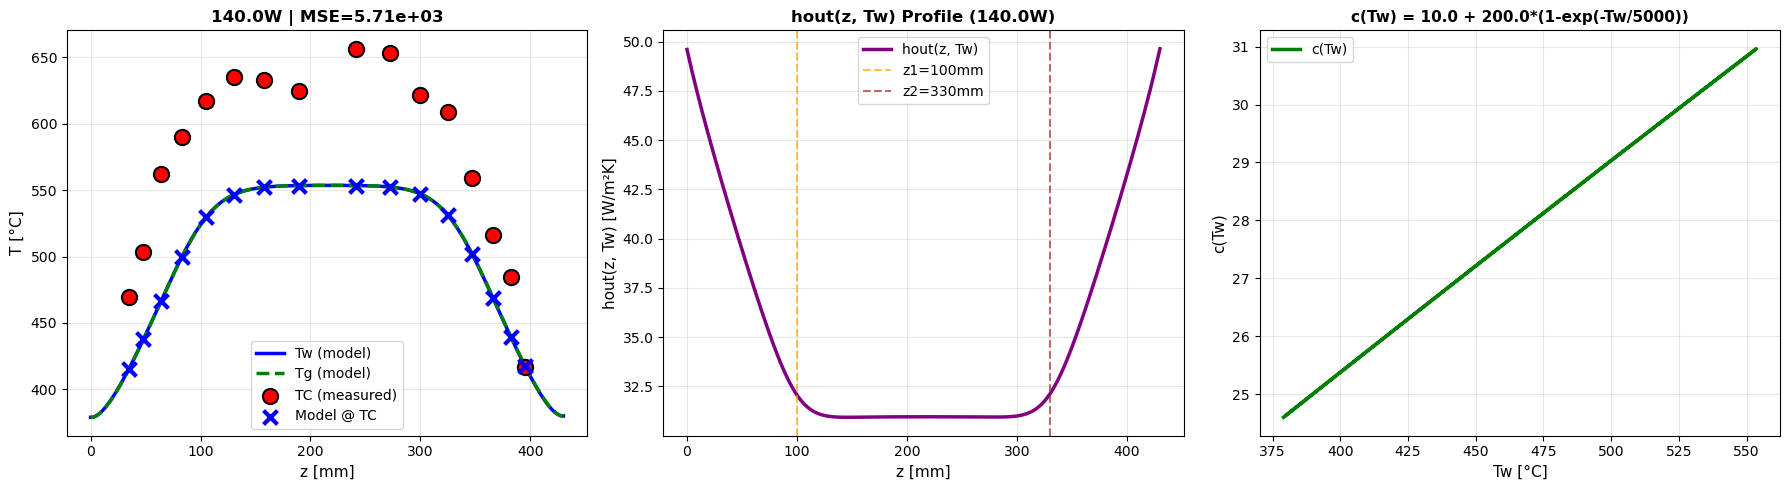


케이스 2 (280.0W):
  Tw range:             619.7 ~ 830.9 °C
  c(Tw) range:          33.315 ~ 40.623
  hout(z=0):            58.316
  hout(z=L/2):          40.624
  hout(z=L):            58.350
  Newton:               ||F||=2.364e-01
  TC MSE:               4.381e+03


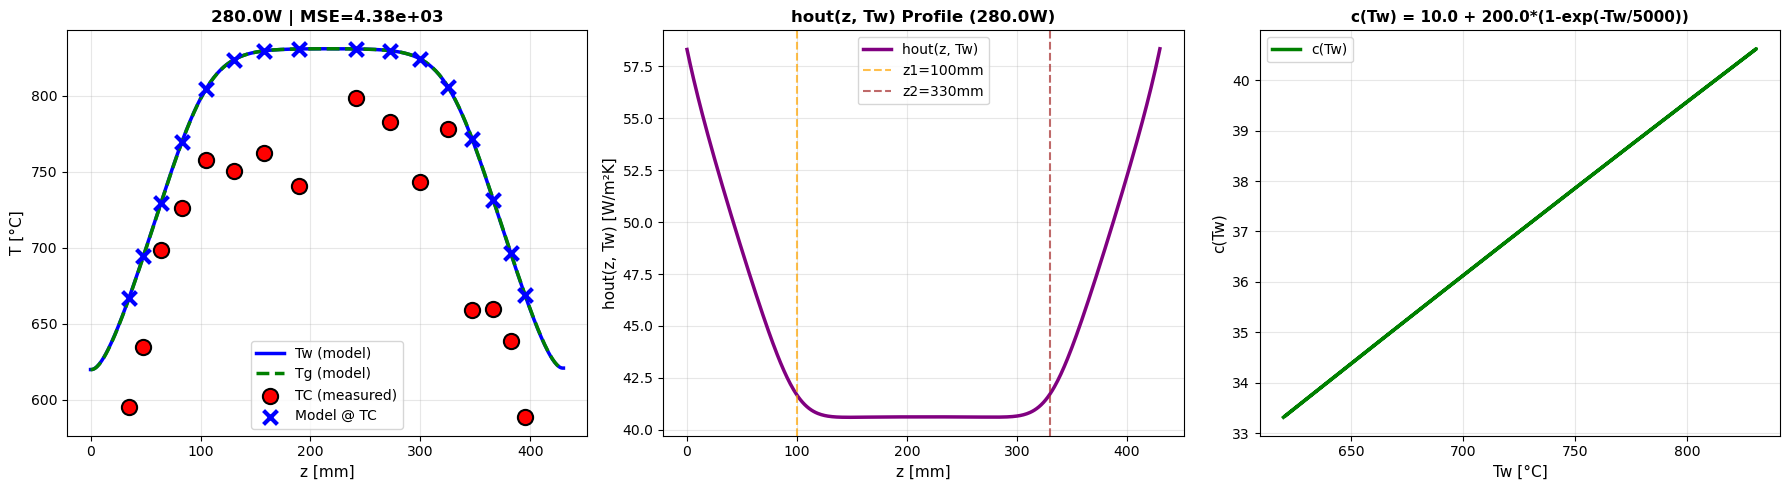


케이스 3 (420.0W):
  Tw range:             817.4 ~ 1050.4 °C
  c(Tw) range:          40.165 ~ 47.896
  hout(z=0):            65.166
  hout(z=L/2):          47.896
  hout(z=L):            65.198
  Newton:               ||F||=4.127e-01
  TC MSE:               4.360e+03


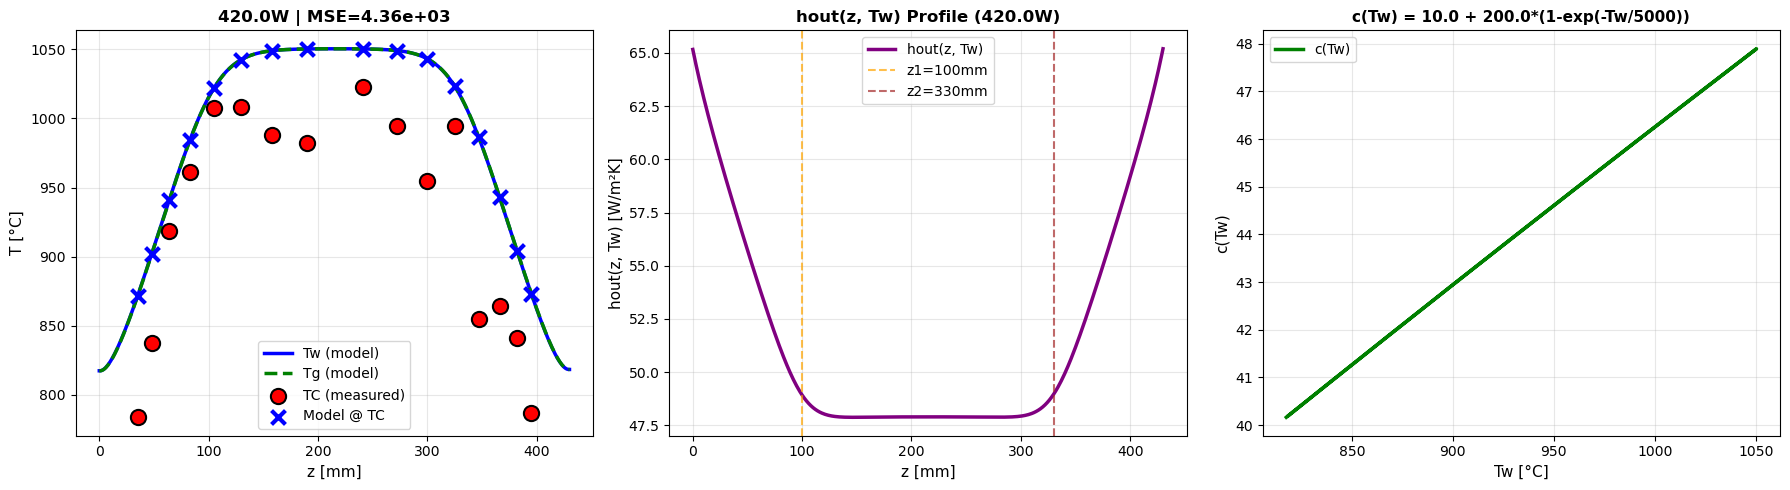


Manual tuning 완료!
파라미터를 수정하고 이 셀을 다시 실행하면 결과를 바로 확인할 수 있습니다.


In [239]:
# 14) Manual Parameter Tuning
# 여기서 파라미터를 직접 수정해서 결과를 확인할 수 있습니다

print("="*80)
print("MANUAL PARAMETER TUNING")
print("="*80)

# 학습된 파라미터를 복사해서 수동 조정
manual_params = jnp.array([
    float(global_params_final[0]),  # c_base
    float(global_params_final[1]),  # c_inf
    float(global_params_final[2]),  # T0
    float(global_params_final[3]),  # m
    float(global_params_final[4])   # k
])

print(f"\n초기 파라미터 (학습 결과):")
print(f"  c_base = {manual_params[0]:.4f}")
print(f"  c_inf  = {manual_params[1]:.4f}")
print(f"  T0     = {manual_params[2]:.3f} °C")
print(f"  m      = {manual_params[3]:.3f}")
print(f"  k      = {manual_params[4]:.3f}")

# =========================================================================
# 🔧 여기서 파라미터를 직접 수정하세요!
# =========================================================================
manual_params = manual_params.at[0].set(10.0)   # c_base 조정
manual_params = manual_params.at[1].set(200.0)   # c_inf 조정
manual_params = manual_params.at[2].set(5000.0)  # T0 조정
manual_params = manual_params.at[3].set(250.0)  # m 조정
manual_params = manual_params.at[4].set(80.0)   # k 조정
# =========================================================================

print(f"\n수정된 파라미터:")
print(f"  c_base = {manual_params[0]:.4f}")
print(f"  c_inf  = {manual_params[1]:.4f}")
print(f"  T0     = {manual_params[2]:.3f} °C")
print(f"  m      = {manual_params[3]:.3f}")
print(f"  k      = {manual_params[4]:.3f}")

print("\n" + "="*80)
print("c(Tw) 함수 미리보기:")
print("="*80)
for T_sample in [0, 300, 500, 700, 900, 1200]:
    c_val = float(manual_params[0]) + float(manual_params[1]) * (1 - np.exp(-T_sample / float(manual_params[2])))
    print(f"  c({T_sample}°C) = {c_val:.3f}")

# 각 케이스에 대해 시뮬레이션
print("\n" + "="*80)
print("Manual 파라미터로 시뮬레이션 결과:")
print("="*80)

for k, Pw_k in enumerate([140., 280., 420.]):
    res_fn = lambda U: residual(U, manual_params, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    # hout(z, Tw) 프로파일 계산
    hout_profile = compute_hout_profile(manual_params, Tw)
    c_Tw_profile = float(manual_params[0]) + float(manual_params[1]) * (1.0 - jnp.exp(-Tw / (float(manual_params[2]) + 1e-6)))
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  Tw range:             {float(Tw.min()):.1f} ~ {float(Tw.max()):.1f} °C")
    print(f"  c(Tw) range:          {float(c_Tw_profile.min()):.3f} ~ {float(c_Tw_profile.max()):.3f}")
    print(f"  hout(z=0):            {float(hout_profile[0]):.3f}")
    print(f"  hout(z=L/2):          {float(hout_profile[n_nodes//2]):.3f}")
    print(f"  hout(z=L):            {float(hout_profile[-1]):.3f}")
    print(f"  Newton:               ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:               {mse:.3e}")
    
    # 온도 프로파일 비교 플롯
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Temperature profile
    axes[0].plot(np.array(z)*1000, np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    axes[0].plot(np.array(z)*1000, np.array(Tg), label='Tg (model)', linewidth=2.5,
                    linestyle='--', color='green')
    axes[0].scatter(np.array(tc_pos)*1000, np.array(T_meas_cases[k]), s=120, c='red',
                       label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    axes[0].scatter(np.array(tc_pos)*1000, np.array(Tw_tc), s=100, c='blue', marker='x',
                       linewidths=3, label='Model @ TC', zorder=5)
    axes[0].set_title(f'{Pw_k}W | MSE={mse:.2e}', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].set_xlabel('z [mm]', fontsize=11)
    axes[0].set_ylabel('T [°C]', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # hout(z, Tw) profile
    axes[1].plot(np.array(z)*1000, np.array(hout_profile), linewidth=2.5, color='purple', label='hout(z, Tw)')
    axes[1].axvline(Z1_FIXED*1000, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z1={Z1_FIXED*1000:.0f}mm')
    axes[1].axvline(Z2_FIXED*1000, color='brown', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z2={Z2_FIXED*1000:.0f}mm')
    axes[1].set_title(f'hout(z, Tw) Profile ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].set_xlabel('z [mm]', fontsize=11)
    axes[1].set_ylabel('hout(z, Tw) [W/m²K]', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # c(Tw) vs Tw
    axes[2].plot(np.array(Tw), np.array(c_Tw_profile), linewidth=2.5, color='green', label='c(Tw)')
    axes[2].set_xlabel('Tw [°C]', fontsize=11)
    axes[2].set_ylabel('c(Tw)', fontsize=11)
    title_str = f'c(Tw) = {float(manual_params[0]):.1f} + {float(manual_params[1]):.1f}*(1-exp(-Tw/{float(manual_params[2]):.0f}))'
    axes[2].set_title(title_str, fontsize=11, fontweight='bold')
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("Manual tuning 완료!")
print("파라미터를 수정하고 이 셀을 다시 실행하면 결과를 바로 확인할 수 있습니다.")
print("="*80)

## Manual Parameter Tuning